In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas_profiling as pp
from IPython.core.display import display

In [3]:
data_path = '/home/james/Downloads/INDEX_20210406.csv'
data = pd.read_csv(data_path)

In [4]:
# printing the first 5 rows of the data
data.head()

,Symbol,Date,Open,High,Low,Close,Volume
0,ADDA.IDX,06-Apr-2021,30.0,38.0,3.0,6.0,0
1,ADDC.IDX,06-Apr-2021,20.0,21.0,-59.0,-37.0,0
2,ADDE.IDX,06-Apr-2021,-72.0,731.0,-72.0,89.0,0
3,ADDN.IDX,06-Apr-2021,288.0,820.0,157.0,295.0,0
4,ADDQ.IDX,06-Apr-2021,-71.0,288.0,-399.0,-318.0,0


In [5]:
# printing the shape of the data
data.shape

(2170, 7)

In [6]:
# data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2170 entries, 0 to 2169
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Symbol  2170 non-null   object 
 1   Date    2170 non-null   object 
 2   Open    2170 non-null   float64
 3   High    2170 non-null   float64
 4   Low     2170 non-null   float64
 5   Close   2170 non-null   float64
 6   Volume  2170 non-null   int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 118.8+ KB


In [8]:
pp.ProfileReport(data)

In [9]:
data.columns

Index(['Symbol', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [10]:
data['Date'].value_counts()

06-Apr-2021    2170
Name: Date, dtype: int64

In [11]:
data.drop('Symbol', axis=1, inplace=True)

In [13]:
#volume
data['Volume'].value_counts().sum()

2170

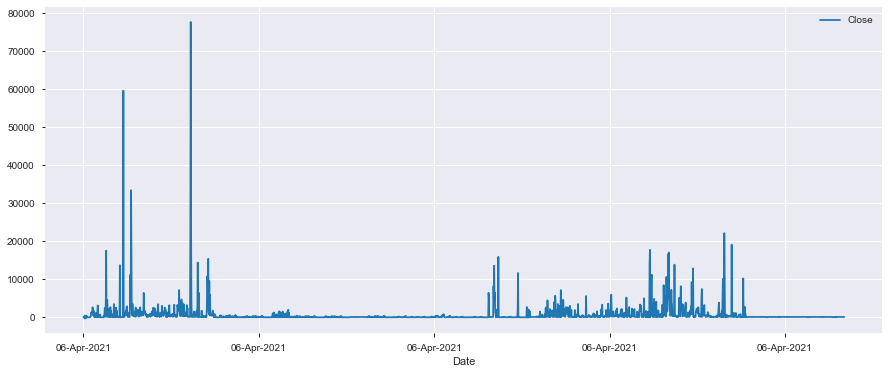

In [18]:
data.plot(x='Date', y='Close', figsize=(15,6))
plt.show()

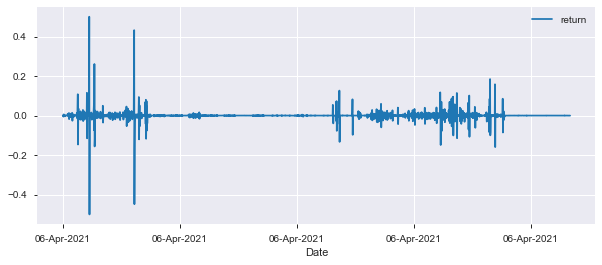

In [20]:
#normalize close value
# we use this value to train the model
data['return'] = data['Close'] - data['Close'].shift(1)
return_range = data['return'].max() - data['return'].min()
data['return'] = data['return'] / return_range

data.plot(x='Date', y='return', figsize=(10,4))
plt.show()

In [21]:
# Make label, 1 as rising price, 0 as falling price
data['label'] = data['return'].shift(-1)
data['label'] = data['label'].apply(lambda x: 1 if x>0.0 else 0)
# data.dropna(inplace=True)
data.tail()

,Date,Open,High,Low,Close,Volume,return,label
2165,06-Apr-2021,90.0,90.0,90.0,90.0,0,0.000168,0
2166,06-Apr-2021,90.0,100.0,90.0,90.0,0,0.000000,1
2167,06-Apr-2021,100.0,100.0,100.0,100.0,0,0.000084,0
2168,06-Apr-2021,100.0,100.0,100.0,100.0,0,0.000000,0
2169,06-Apr-2021,80.0,80.0,80.0,80.0,0,-0.000168,0


In [25]:
# Make training dataset

n_features = 60 # number of features

train_x = np.array([]).reshape([-1,n_features])
train_y = np.array([]).reshape([-1,1])
for index, row in data.iterrows():
    i = data.index.get_loc(index)
    if i<n_features:
        continue
    
    _x = np.array(data[i-n_features+1:i+1]['return']).T.reshape([1, -1])
    _y = data.loc[i]['label']
    train_x = np.vstack((train_x, _x))
    train_y = np.vstack((train_y, _y))
train_y = train_y.reshape([-1])
print(train_x.shape)
print(train_y.shape)
print('%% of Class0 : %f' % (np.count_nonzero(train_y == 0)/float(len(train_y))))
print('%% of Class1 : %f' % (np.count_nonzero(train_y == 1)/float(len(train_y))))

(2110, 60)
(2110,)
% of Class0 : 0.511848
% of Class1 : 0.488152


In [26]:
# Define Model and fit
# Here we use 95% of data for training, and last 5% for testing

from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=0, learning_rate=0.01, n_estimators=10000)

train_len = int(len(train_x)*0.95)
clf.fit(train_x[:train_len], train_y[:train_len])

accuracy = clf.score(train_x[train_len:], train_y[train_len:])
print('Testing Accuracy: %f' % accuracy)

Testing Accuracy: 0.660377


,return,label,pred,won,pnl,equity
100,20.0,1.0,1.0,True,200000.0,7350900.0
101,0.0,0.0,0.0,True,0.0,7350900.0
102,10.0,1.0,1.0,True,100000.0,7450900.0
103,0.0,0.0,0.0,True,0.0,7450900.0
104,-20.0,0.0,0.0,True,200000.0,7650900.0


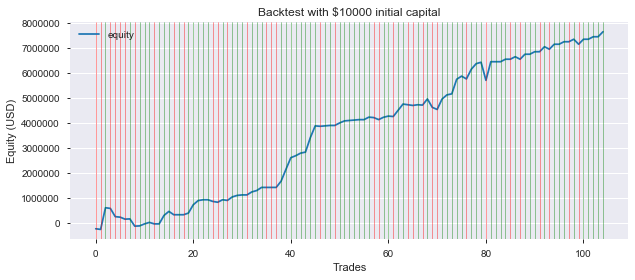

In [27]:
# Predict test data

pred = clf.predict(train_x[train_len:])


# Calculate equity..

contracts  = 10000.0
commission = 0.0


df_trade = pd.DataFrame(train_x[train_len:,-1], columns=['return'])
df_trade['label']  = train_y[train_len:]
df_trade['pred']   = pred
df_trade['won']    = df_trade['label'] == df_trade['pred']
df_trade['return'] = df_trade['return'].shift(-1) * return_range
df_trade.drop(df_trade.index[len(df_trade)-1], inplace=True)

def calc_profit(row):
    if row['won']:
        return abs(row['return'])*contracts - commission
    else:
        return -abs(row['return'])*contracts - commission

df_trade['pnl'] = df_trade.apply(lambda row: calc_profit(row), axis=1)
df_trade['equity'] = df_trade['pnl'].cumsum()

display(df_trade.tail())
df_trade.plot(y='equity', figsize=(10,4), title='Backtest with $10000 initial capital')
plt.xlabel('Trades')
plt.ylabel('Equity (USD)')
for r in df_trade.iterrows():
    if r[1]['won']:
        plt.axvline(x=r[0], linewidth=0.5, alpha=0.8, color='g')
    else:
        plt.axvline(x=r[0], linewidth=0.5, alpha=0.8, color='r')

Net Profit            : $7650900.00
Number Winning Trades : 60
Number Losing Trades  : 26
Percent Profitable    : 69.77%
Avg Win Trade         : $180608.333
Avg Los Trade         : $-122523.077
Largest Win Trade     : $868400.000
Largest Los Trade     : $-722200.000
Profit Factor         : 3.40


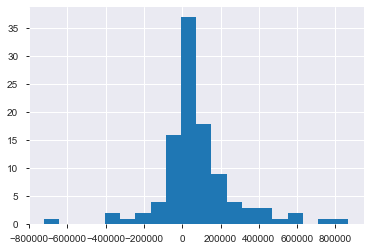

In [28]:
# Calculate summary of trades

n_win_trades = float(df_trade[df_trade['pnl']>0.0]['pnl'].count())
n_los_trades = float(df_trade[df_trade['pnl']<0.0]['pnl'].count())
print("Net Profit            : $%.2f" % df_trade.tail(1)['equity'])
print("Number Winning Trades : %d" % n_win_trades)
print("Number Losing Trades  : %d" % n_los_trades)
print("Percent Profitable    : %.2f%%" % (100*n_win_trades/(n_win_trades + n_los_trades)))
print("Avg Win Trade         : $%.3f" % df_trade[df_trade['pnl']>0.0]['pnl'].mean())
print("Avg Los Trade         : $%.3f" % df_trade[df_trade['pnl']<0.0]['pnl'].mean())
print("Largest Win Trade     : $%.3f" % df_trade[df_trade['pnl']>0.0]['pnl'].max())
print("Largest Los Trade     : $%.3f" % df_trade[df_trade['pnl']<0.0]['pnl'].min())
print("Profit Factor         : %.2f" % abs(df_trade[df_trade['pnl']>0.0]['pnl'].sum()/df_trade[df_trade['pnl']<0.0]['pnl'].sum()))

df_trade['pnl'].hist(bins=20)